In [1]:
%load_ext autoreload

In [89]:
%autoreload 2
import cmath
from datetime import datetime
from kneed import KneeLocator
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import construct_dictionary, embed_signal, perform_stability_analysis, get_stability_results, compute_EDMD, predict_EDMD, compute_VAR_p, compute_VAR_p_over_lamb, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Delayed MI

In [7]:
# data = lfp[:int(session_info['drugStart'][0]/dt)]
# num_lags = 200

# delayed_mi = np.zeros((num_lags + 1, data.shape[1]))
# for i in tqdm(range(num_lags + 1)):
#     for j in range(data.shape[1]):
# #     for j in [0]:
#         delayed_mi[i, j] = delay.mi(data[:data.shape[0] - i:, j], data[i:, j], bins=64)

# pd.to_pickle(delayed_mi, 'delayed_mi_wake.pkl')

In [8]:
delayed_mi = pd.read_pickle('delayed_mi_wake.pkl')

In [9]:
def pick_tau(signal, method='knee'):
    if method == 'local_min':
        local_min_inds = scipy.signal.argrelextrema(signal, np.less)[0]
        if len(local_min_inds) == 0:
            tau = signal.argmin()
        else:
            tau = local_min_inds[0]
    else: # method == 'knee'
        kneedle = KneeLocator(np.arange(len(signal)), signal, S=1, curve='convex', direction='decreasing')
    
    return kneedle.knee

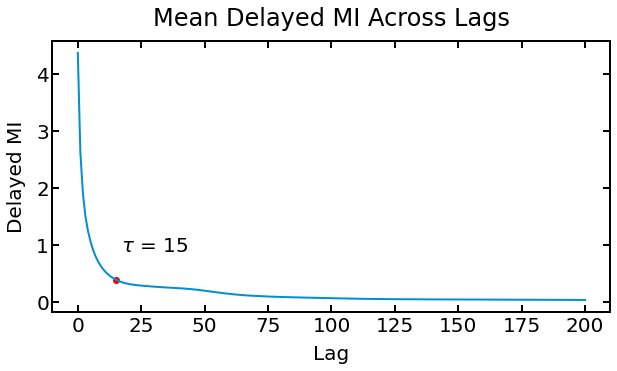

In [10]:
# dim = 23
# tau = pick_tau(delayed_mi[:, dim])
# plt.plot(delayed_mi[:, dim])
# plt.scatter(tau, delayed_mi[tau, dim], c='red')
# plt.xlabel('Lag')
# plt.ylabel('Delayed MI')
# plt.title(f'Delayed MI Dimension {dim}')
# plt.text(tau + 2, delayed_mi[tau, dim] + 0.5, fr"$\tau$ = {tau}")
# plt.show()

mean_delayed_mi = delayed_mi.mean(axis=1)
tau = pick_tau(mean_delayed_mi)

plt.plot(mean_delayed_mi)
plt.scatter(tau, mean_delayed_mi[tau], c='red')
plt.xlabel('Lag')
plt.ylabel('Delayed MI')
plt.title('Mean Delayed MI Across Lags')
plt.text(tau + 2, mean_delayed_mi[tau] + 0.5, fr"$\tau$ = {tau}")
plt.show()

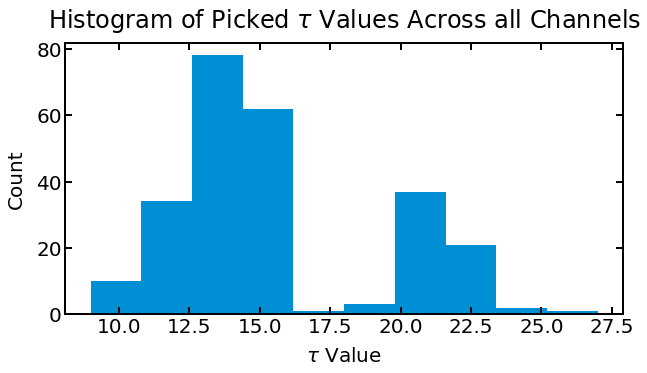

In [11]:
taus = []
for j in range(delayed_mi.shape[1]):
    taus.append(pick_tau(delayed_mi[:, j]))

plt.hist(taus)
plt.xlabel(r'$\tau$ Value')
plt.ylabel('Count')
plt.title(r'Histogram of Picked $\tau$ Values Across all Channels')
plt.show()

In [13]:
lfp_subsampled = lfp[np.arange(0, lfp.shape[0], tau)]

# Testing Out

In [14]:
dt_eff = dt*tau

In [17]:
dt_eff * 60000

900.0

In [26]:
wake_start = 1 # s
anesthesia_start = session_info['drugStart'][1] + 120

duration = 480 # s

area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

signals = {}
signals['wake'] = lfp_subsampled[int(wake_start/dt_eff):int(wake_start/dt_eff) + int(duration/dt_eff), unit_indices]
signals['anesthesia'] = lfp_subsampled[int(anesthesia_start/dt_eff):int(anesthesia_start/dt_eff) + int(duration/dt_eff), unit_indices]

In [59]:
lamb_vals = [0, 1e-12, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 2, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60]
max_lag = 8
lags = np.arange(1, max_lag + 1)
windows = np.hstack([np.arange(2, 7.1, 1), np.arange(500, 6001, 500)*dt_eff])
kwargs = dict(
    windows = windows,
    lags = lags,
    method = 'VAR(p)',
    T_pred = 100,
    num_window_samples=5,
    dt = dt_eff,
    lamb = lamb_vals,
    trim_CIs = False,
    use_lamb_for_full_results = True,
    verbose = 2
)


In [45]:
signal_analysis = {}
for key, signal in signals.items():
    ret = perform_stability_analysis(signals[key], **kwargs)
    full_results, grid_search_df, test_mse_mat, window, p, lamb_full = ret
    signal_analysis[key] = dict(
        VAR_results=full_results,
        grid_search_df=grid_search_df,
        test_mse_mat=test_mse_mat,
        window=window,
        p=p,
        lamb_full=lamb_full
    )

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

0.5

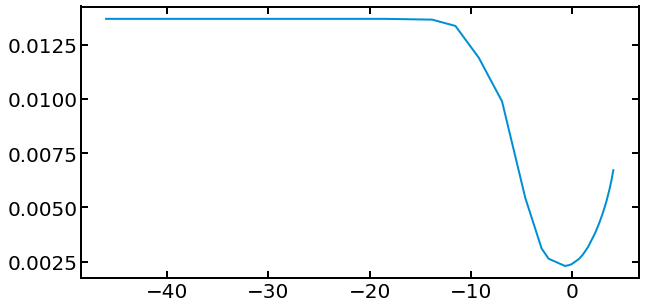

In [85]:
gsd = signal_analysis['anesthesia']['grid_search_df']
plt.plot(np.log(np.array(lamb_vals) + 1e-20), gsd.lamb_mses.iloc[0])
gsd.lamb.iloc[0]

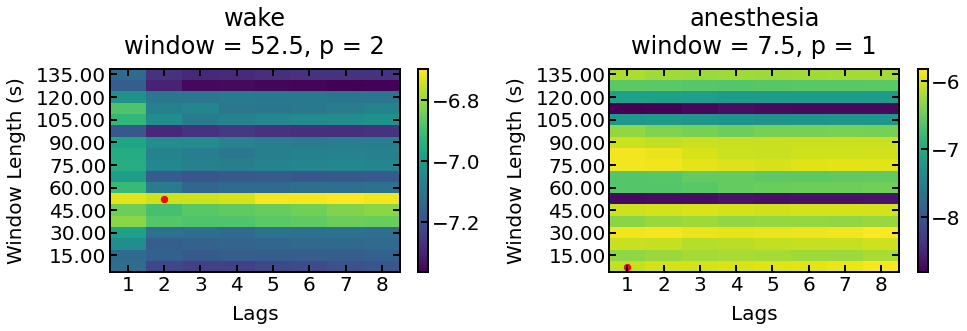

In [46]:

plt.style.use('../../sci_style.py')
rows = 1
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(14, 5))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    log_test_mse_mat = np.log(signal_info['test_mse_mat'])
    im = ax.pcolormesh(log_test_mse_mat)
    ax.set_xticks(lags - 0.5)
    ax.set_xticklabels([lag for lag in lags])
    ax.set_yticks(np.arange(1, len(windows), 2) + 0.5)
    ax.set_yticklabels([f"{windows[i]:.2f}" for i in np.arange(1, len(windows), 2)])
    ax.set_xlabel('Lags')
    ax.set_ylabel('Window Length (s)')
    ax.set_title(f"{key}\nwindow = {signal_info['window']}, p = {signal_info['p']}")
    fig.colorbar(im, ax=ax)
    p_ind = np.where(lags == signal_info['p'])[0][0]
    w_ind = np.where(np.array(windows) == signal_info['window'])[0][0]
    ax.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()

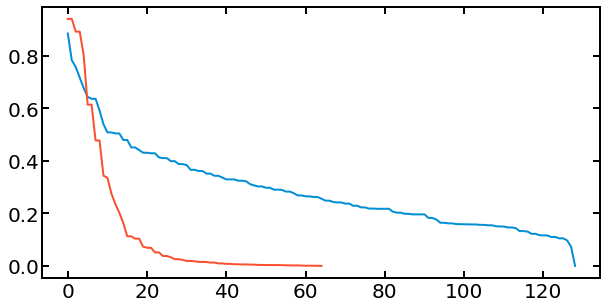

In [48]:
plt.plot(signal_analysis['wake']['VAR_results'].criticality_inds.iloc[0])
plt.plot(signal_analysis['anesthesia']['VAR_results'].criticality_inds.iloc[0])
plt.show()

In [52]:
signal_analysis['anesthesia']['VAR_results']

,explained_variance,coefs,intercept,eigs,criticality_inds,S,info_criteria,lamb,train_mse,test_mse,pb_mse_train,pb_mse_test,start_ind,end_ind,p,T_pred,start_time,end_time,window,stride
0,None,"[[[0.35024037765922805, 0.19582228151333178, 0...","[0.0018965427918625378, -0.0005355340689259216...","[(0.9358838685172335+0.09627570394580429j), (0...","[0.9408228454502168, 0.9408228454502168, 0.892...","[29.92812213590061, 22.34856880319594, 7.65726...",None,0.75,0.001660,0.002563,0.002203,0.002617,0,500,1,100,0.0,7.5,7.5,7.5
1,None,"[[[0.21082984364939625, 0.14179997029088276, 0...","[-0.0028708491623897292, -0.002122566434897689...","[(0.9358225617765491+0j), (0.910497893528591+0...","[0.9358225617765491, 0.9135298658290205, 0.913...","[23.20012426758057, 22.331185313527328, 7.0521...",None,0.75,0.001361,0.004110,0.001643,0.004097,500,1000,1,100,7.5,15.0,7.5,7.5
2,None,"[[[0.36603659128151683, 0.1978147954007856, -0...","[-0.003737265706463313, -0.003859651652993255,...","[(0.9284603729492383+0.10421925113709148j), (0...","[0.9342913445197996, 0.9342913445197996, 0.866...","[33.95579632325493, 22.316509489364996, 7.6239...",None,0.75,0.001634,0.001630,0.002237,0.001927,1000,1500,1,100,15.0,22.5,7.5,7.5
3,None,"[[[0.31295821569568105, 0.1755958795700165, 0....","[0.0045844648214289465, 0.001361094912879472, ...","[(0.9419973927277379+0.08013089228390657j), (0...","[0.9453994117853423, 0.9453994117853423, 0.860...","[32.554530522926896, 22.058114808710208, 7.919...",None,0.75,0.001775,0.000773,0.002303,0.000813,1500,2000,1,100,22.5,30.0,7.5,7.5
4,None,"[[[0.3362539577976086, 0.201794556709928, 0.08...","[-0.0035520396818562627, -0.000650096075509086...","[(0.9274170809115149+0.10548336380346329j), (0...","[0.9333965834551405, 0.9333965834551405, 0.892...","[32.90059352598837, 22.14436578375333, 7.00525...",None,0.75,0.001696,0.002117,0.002230,0.002274,2000,2500,1,100,30.0,37.5,7.5,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,None,"[[[0.4386124754277162, 0.20369174298421602, 0....","[0.0006383613658059341, 0.001463017465250493, ...","[(0.9532755114911207+0.07598495647771585j), (0...","[0.9562990716400274, 0.9562990716400274, 0.937...","[34.52645022360476, 22.31302471173814, 9.96929...",None,0.75,0.001456,0.001770,0.001868,0.002014,29000,29500,1,100,435.0,442.5,7.5,7.5
59,None,"[[[0.3118964285447274, 0.18723801353868194, 0....","[-0.0036067816696733032, -0.000878745388447509...","[(0.9226368053067483+0.08574802319637086j), (0...","[0.9266128630602577, 0.9266128630602577, 0.918...","[35.60254807371727, 22.184209240784924, 8.3575...",None,0.75,0.001906,0.002563,0.002514,0.002747,29500,30000,1,100,442.5,450.0,7.5,7.5
60,None,"[[[0.36767505342071166, 0.26027387551678, 0.08...","[0.0043260023665321855, 0.00361237331449869, 0...","[(0.9470070804834474+0.0627505402099478j), (0....","[0.949083790179994, 0.949083790179994, 0.90745...","[34.1234667977931, 22.155858423375307, 9.46858...",None,0.75,0.001463,0.002560,0.001913,0.002926,30000,30500,1,100,450.0,457.5,7.5,7.5
61,None,"[[[0.2983298275743557, 0.19326972667689687, 0....","[-0.003752472765622531, -0.001683308288092216,...","[(0.9486498515217631+0.08660492991895319j), (0...","[0.9525948533760457, 0.9525948533760457, 0.938...","[38.236957145943045, 22.258650698030213, 10.10...",None,0.75,0.002001,0.001299,0.002642,0.001614,30500,31000,1,100,457.5,465.0,7.5,7.5


In [73]:
predictions = {}
true_vals = {}
pb_mses = {}
pbs = {}
for key in signal_analysis.keys():
    row = signal_analysis[key]['VAR_results'].iloc[0]
    predictions[key], true_vals[key], pb_mses[key], pbs[key] = predict_VAR_p(signals[key][row.end_ind:row.end_ind + row.T_pred], row.coefs, row.intercept, persistence_baseline=2)

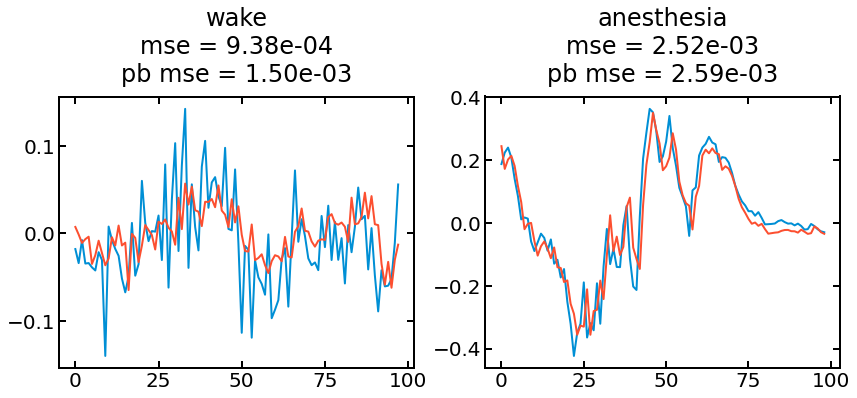

In [107]:
dim = 0
plt.style.use('../../sci_style.py')
rows = 1
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(14, 5))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    ax.plot(true_vals[key][:, dim], label='true values')
    ax.plot(predictions[key][:, dim], label='predictions')
    ax.set_title(f"{key}\nmse = {((predictions[key] - true_vals[key])**2).mean():.2e}\npb mse = {pb_mses[key]:.2e}")

In [188]:
p = 5
normalize = True
PCA_dim = 4
max_order = 4
grouped_by = PCA_dim

N_groups = int(np.ceil(PCA_dim*p/grouped_by))
N_funcs = ((max_order + 1)**grouped_by - 1)*N_groups + 1
N_funcs

3121

In [199]:
# results = compute_VAR_p_over_lamb(signals['wake'][:10000], test_data=signals['wake'][10000 - p:10100], p=p, PCA_dim=PCA_dim, lamb_vals=lamb_vals, normalize=normalize)
results = compute_EDMD(signals['wake'][:10000], p=p, lamb=100, trim_CIs=False, PCA_dim=PCA_dim, dictionary_method='hermite', max_order=max_order, grouped_by=grouped_by, normalize=normalize)

(9996, 3121)


In [204]:
# preds, tv, pb_mse, pb = predict_VAR_p(signals['wake'][10000 - p:10100], results['coefs'], results['intercept'], PCA_dim=PCA_dim, persistence_baseline=2, normalize=normalize)
# preds, tv, pb_mse, pb = predict_VAR_p(signals['wake'][:10000], results['coefs'], results['intercept'], PCA_dim=PCA_dim, normalize=normalize, persistence_baseline=2)

predict_type = 'actual'
# preds, tv, pb_mse, pb = predict_EDMD(signals['wake'][10000 - p:10100], results['coefs'], predict_type=predict_type, p=p, PCA_dim=PCA_dim, intercept=results['intercept'], persistence_baseline=2, dictionary_method='hermite', max_order=max_order, grouped_by=grouped_by, normalize=normalize)
preds, tv, pb_mse, pb = predict_EDMD(signals['wake'][:10000], results['coefs'], predict_type=predict_type, p=p, PCA_dim=PCA_dim, intercept=results['intercept'], persistence_baseline=2, dictionary_method='hermite', max_order=max_order, grouped_by=grouped_by, normalize=normalize)

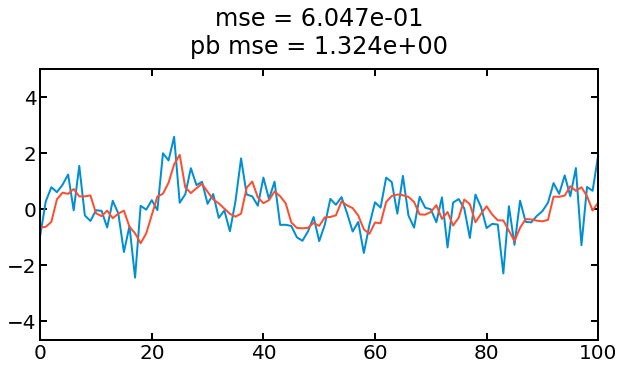

In [206]:
dim = 0
plt.plot(tv[:, dim])
plt.plot(preds[:, dim])
plt.title(f"mse = {((preds - tv)**2).mean():.3e}\npb mse = {pb_mse:.3e}")
plt.xlim([0, 100])
plt.show()

In [202]:
np.sum(results['criticality_inds'] > 1)

0

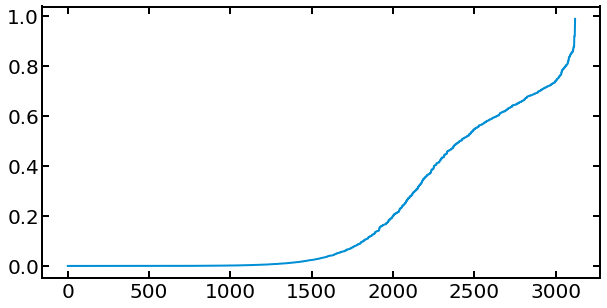

In [203]:
plt.plot(results['criticality_inds'])

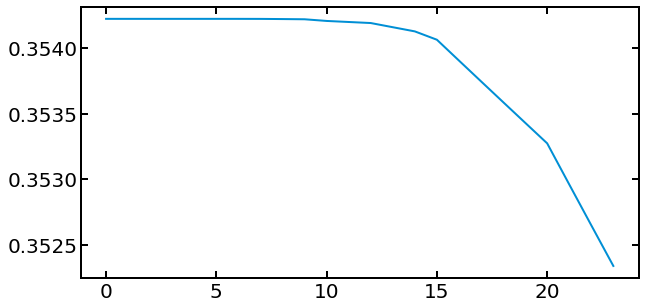

In [165]:
plt.plot(results['lamb_mses'])